# STEP : Rarefaction Analysis

Using QIIME2 to create rarefaction graphs.


## Methods
[qiime alpha_rarefaction](https://docs.qiime2.org/2023.2/plugins/available/diversity/alpha-rarefaction/)
```
Generate interactive alpha rarefaction curves by computing rarefactions
between `min_depth` and `max_depth`. The number of intermediate depths to
compute is controlled by the `steps` parameter, with n `iterations` being
computed at each rarefaction depth. If sample metadata is provided, samples
may be grouped based on distinct values within a metadata column.
```


## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [4]:
# Parameters
experiment_name = "thayane-PM-joined-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-thayane"
manifest_file = (
    "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/manifest-single.csv"
)
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/metadata.tsv"
class_col = "above_10"
classifier_file = (
    "/home/lauro/nupeb/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
)
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6


### Defining names, paths and flags

In [5]:
# Experiments
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
!mkdir -p {experiment_folder}

# Imgs folder
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
!mkdir -p {img_folder}

# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
!mkdir -p {qiime_folder}

In [6]:
# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Output -Rarefaction Artifacts
alpha_rarefaction_path = os.path.join(qiime_folder, 'alpha-rarefaction.qza')
alpha_rarefaction_view_path = os.path.join(qiime_folder, 'alpha-rarefaction.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_rarefaction_path)) or replace_files
need_view = not (os.path.isfile(alpha_rarefaction_view_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

In [8]:
alt_tab_path = os.path.join(base_dir, 'data', 'interim', 'dada2-tabs.qza')
# Verify if table file exists and if it is shared
if not os.path.isfile(dada2_tabs_path) and os.path.isfile(alt_tab_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_tab_path, dada2_tabs_path)

In [9]:
# Load Table artifact
tabs = Artifact.load(dada2_tabs_path)
# Filter samples using Metadata IDs
tabs = filter_samples(
    table=tabs,
    metadata=metadata_qa,
).filtered_table
tabs_df = tabs.view(Metadata).to_dataframe().T

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
44 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
44 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnP

## Alpha Rarefaction

In [10]:
# Get min and maximum feature counts to set sampling depth
rank_df = tabs_df.sum().sort_values()
min_feature_count = int(rank_df.min())
max_feature_count = int(rank_df.max())

In [11]:
# Add new columns with samples IDs to rarefaction
meta_df = metadata_qa.to_dataframe()
meta_df['samples'] = meta_df.index.to_list()
metadata_qa = Metadata(meta_df)

In [12]:
alpha_rar = alpha_rarefaction(
    table = tabs,
    max_depth = max_feature_count,
    min_depth = 1,
    metadata = metadata_qa,
)

{'max_depth': 246542, 'metrics': None, 'metadata': Metadata
--------
44 IDs x 9 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')
samples:            ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'min_depth': 1, 'steps': 10, 'iterations': 10, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense), 'phylogeny': None}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class '

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9b92f6e6-2f91-4695-bc27-4ad17e7dd442>}
{'drop_undefined_samples': False, 'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 34e1d4a0-254c-44bc-a46a-777d26157480>}
{'table': 38 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 38 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 34e1d4a0-254c-44bc-a46a-777d26157480>}
{'drop_undefined_samples': False, 'table': 38 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 38 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4f690112-072c-49e1-8d1b-8a113e57d7f0>}


{'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4f690112-072c-49e1-8d1b-8a113e57d7f0>}
{'drop_undefined_samples': False, 'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 38592091-0e08-48c2-bcc7-b949460b5119>}
{'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 38592091-0e08-48c2-bcc7-b949460b5119>}
{'drop_undefined_samples': False, 'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ab25f7b9-b0e4-4bfb-8ce9-f4c69138eb93>}
{'table': 36 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 36 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ab25f7b9-b0e4-4bfb-8ce9-f4c69138eb93>}
{'drop_undefined_samples': False, 'table': 36 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 36 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a7e347da-520d-419f-bad7-39e768073cc5>}
{'table': 39 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 39 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a7e347da-520d-419f-bad7-39e768073cc5>}
{'drop_undefined_samples': False, 'table': 39 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 39 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: fcbe2474-afce-479c-859d-495274e507a7>}
{'table': 41 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 41 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: fcbe2474-afce-479c-859d-495274e507a7>}
{'drop_undefined_samples': False, 'table': 41 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 41 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3c4da88e-aa8d-4016-8239-18b257d7efd9>}
{'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3c4da88e-aa8d-4016-8239-18b257d7efd9>}
{'drop_undefined_samples': False, 'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 37 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b491b27d-f5b2-4ccf-9a06-3d2c751d573f>}
{'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b491b27d-f5b2-4ccf-9a06-3d2c751d573f>}
{'drop_undefined_samples': False, 'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 43 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 44b08477-0f07-40e5-b1ea-0d339e2440c5>}
{'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 44b08477-0f07-40e5-b1ea-0d339e2440c5>}
{'drop_undefined_samples': False, 'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 40 x 44 <class 'biom.table.Table'> with 44 nonzero entries (2% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c766eed0-2c48-4aad-861e-f3e5b0041f40>}
{'table': 2027 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'table': 2027 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c766eed0-2c48-4aad-861e-f3e5b0041f40>}
{'drop_undefined_samples': False, 'table': 2027 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2027 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 12692c42-b362-4674-8275-a2b149b77d43>}
{'table': 2040 x 38 <class 'biom.table.Table'> with 5523 nonzero entries (7% dense)}
{'table': 2040 x 38 <class 'biom.table.Table'> with 5523 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 12692c42-b362-4674-8275-a2b149b77d43>}
{'drop_undefined_samples': False, 'table': 2040 x 38 <class 'biom.table.Table'> with 5523 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2040 x 38 <class 'biom.table.Table'> with 5523 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d73c1f6b-c8f4-4c85-94e1-7cb6f89a9be6>}
{'table': 2030 x 38 <class 'biom.table.Table'> with 5510 nonzero entries (7% dense)}
{'table': 2030 x 38 <class 'biom.table.Table'> with 5510 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d73c1f6b-c8f4-4c85-94e1-7cb6f89a9be6>}
{'drop_undefined_samples': False, 'table': 2030 x 38 <class 'biom.table.Table'> with 5510 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2030 x 38 <class 'biom.table.Table'> with 5510 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9d1bd265-2f41-4a3a-afb0-7fafcc4f44f9>}
{'table': 2020 x 38 <class 'biom.table.Table'> with 5507 nonzero entries (7% dense)}
{'table': 2020 x 38 <class 'biom.table.Table'> with 5507 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9d1bd265-2f41-4a3a-afb0-7fafcc4f44f9>}
{'drop_undefined_samples': False, 'table': 2020 x 38 <class 'biom.table.Table'> with 5507 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2020 x 38 <class 'biom.table.Table'> with 5507 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 427215e7-54d9-49d0-b40b-81eaaec2b561>}
{'table': 2046 x 38 <class 'biom.table.Table'> with 5524 nonzero entries (7% dense)}
{'table': 2046 x 38 <class 'biom.table.Table'> with 5524 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 427215e7-54d9-49d0-b40b-81eaaec2b561>}
{'drop_undefined_samples': False, 'table': 2046 x 38 <class 'biom.table.Table'> with 5524 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2046 x 38 <class 'biom.table.Table'> with 5524 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3ff89c66-3840-4105-837c-2925bf662bfa>}
{'table': 2037 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'table': 2037 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3ff89c66-3840-4105-837c-2925bf662bfa>}
{'drop_undefined_samples': False, 'table': 2037 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2037 x 38 <class 'biom.table.Table'> with 5512 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 489046c4-49bd-43ad-889a-9a7e4e493c0b>}
{'table': 2038 x 38 <class 'biom.table.Table'> with 5528 nonzero entries (7% dense)}
{'table': 2038 x 38 <class 'biom.table.Table'> with 5528 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 489046c4-49bd-43ad-889a-9a7e4e493c0b>}
{'drop_undefined_samples': False, 'table': 2038 x 38 <class 'biom.table.Table'> with 5528 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2038 x 38 <class 'biom.table.Table'> with 5528 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f56fec2e-0376-4c16-aaf9-889a82ac3711>}
{'table': 2037 x 38 <class 'biom.table.Table'> with 5522 nonzero entries (7% dense)}
{'table': 2037 x 38 <class 'biom.table.Table'> with 5522 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f56fec2e-0376-4c16-aaf9-889a82ac3711>}
{'drop_undefined_samples': False, 'table': 2037 x 38 <class 'biom.table.Table'> with 5522 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2037 x 38 <class 'biom.table.Table'> with 5522 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9ae7a3ab-e536-4df2-80eb-f30bcd36f283>}
{'table': 2067 x 38 <class 'biom.table.Table'> with 5545 nonzero entries (7% dense)}
{'table': 2067 x 38 <class 'biom.table.Table'> with 5545 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9ae7a3ab-e536-4df2-80eb-f30bcd36f283>}
{'drop_undefined_samples': False, 'table': 2067 x 38 <class 'biom.table.Table'> with 5545 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2067 x 38 <class 'biom.table.Table'> with 5545 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a3eeff6f-7545-4318-929d-a353e6c69588>}
{'table': 2043 x 38 <class 'biom.table.Table'> with 5527 nonzero entries (7% dense)}
{'table': 2043 x 38 <class 'biom.table.Table'> with 5527 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a3eeff6f-7545-4318-929d-a353e6c69588>}
{'drop_undefined_samples': False, 'table': 2043 x 38 <class 'biom.table.Table'> with 5527 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 2043 x 38 <class 'biom.table.Table'> with 5527 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3f0122fd-50bf-464b-ad8f-18662116bff2>}
{'table': 1951 x 30 <class 'biom.table.Table'> with 4633 nonzero entries (7% dense)}
{'table': 1951 x 30 <class 'biom.table.Table'> with 4633 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3f0122fd-50bf-464b-ad8f-18662116bff2>}
{'drop_undefined_samples': False, 'table': 1951 x 30 <class 'biom.table.Table'> with 4633 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1951 x 30 <class 'biom.table.Table'> with 4633 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b37eaedf-a0c1-4860-af62-7a58b235aa4f>}
{'table': 1949 x 30 <class 'biom.table.Table'> with 4630 nonzero entries (7% dense)}
{'table': 1949 x 30 <class 'biom.table.Table'> with 4630 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b37eaedf-a0c1-4860-af62-7a58b235aa4f>}
{'drop_undefined_samples': False, 'table': 1949 x 30 <class 'biom.table.Table'> with 4630 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1949 x 30 <class 'biom.table.Table'> with 4630 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9d922c30-1013-4096-b528-515332c7860d>}
{'table': 1954 x 30 <class 'biom.table.Table'> with 4632 nonzero entries (7% dense)}
{'table': 1954 x 30 <class 'biom.table.Table'> with 4632 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9d922c30-1013-4096-b528-515332c7860d>}
{'drop_undefined_samples': False, 'table': 1954 x 30 <class 'biom.table.Table'> with 4632 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1954 x 30 <class 'biom.table.Table'> with 4632 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 98330149-1f7c-428c-9fb1-bdd7cc2e0c0e>}
{'table': 1940 x 30 <class 'biom.table.Table'> with 4621 nonzero entries (7% dense)}
{'table': 1940 x 30 <class 'biom.table.Table'> with 4621 nonzero entries (7% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 98330149-1f7c-428c-9fb1-bdd7cc2e0c0e>}
{'drop_undefined_samples': False, 'table': 1940 x 30 <class 'biom.table.Table'> with 4621 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1940 x 30 <class 'biom.table.Table'> with 4621 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 09b7d361-e45b-452f-b566-bc54dedd0a06>}
{'table': 1957 x 30 <class 'biom.table.Table'> with 4636 nonzero entries (7% dense)}
{'table': 1957 x 30 <class 'biom.table.Table'> with 4636 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 09b7d361-e45b-452f-b566-bc54dedd0a06>}
{'drop_undefined_samples': False, 'table': 1957 x 30 <class 'biom.table.Table'> with 4636 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1957 x 30 <class 'biom.table.Table'> with 4636 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 34f5999a-9f7d-46d9-a723-571ee5c6d08d>}
{'table': 1952 x 30 <class 'biom.table.Table'> with 4628 nonzero entries (7% dense)}
{'table': 1952 x 30 <class 'biom.table.Table'> with 4628 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 34f5999a-9f7d-46d9-a723-571ee5c6d08d>}
{'drop_undefined_samples': False, 'table': 1952 x 30 <class 'biom.table.Table'> with 4628 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1952 x 30 <class 'biom.table.Table'> with 4628 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8f2c47e0-3496-4129-bd49-b5815d47eeae>}
{'table': 1967 x 30 <class 'biom.table.Table'> with 4646 nonzero entries (7% dense)}
{'table': 1967 x 30 <class 'biom.table.Table'> with 4646 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8f2c47e0-3496-4129-bd49-b5815d47eeae>}
{'drop_undefined_samples': False, 'table': 1967 x 30 <class 'biom.table.Table'> with 4646 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1967 x 30 <class 'biom.table.Table'> with 4646 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8437b2c3-a67f-4614-9568-ba97a84eb2fd>}
{'table': 1963 x 30 <class 'biom.table.Table'> with 4639 nonzero entries (7% dense)}
{'table': 1963 x 30 <class 'biom.table.Table'> with 4639 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8437b2c3-a67f-4614-9568-ba97a84eb2fd>}
{'drop_undefined_samples': False, 'table': 1963 x 30 <class 'biom.table.Table'> with 4639 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1963 x 30 <class 'biom.table.Table'> with 4639 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: fed4f5f4-1253-4bdd-9e05-73e5825db2c7>}
{'table': 1952 x 30 <class 'biom.table.Table'> with 4631 nonzero entries (7% dense)}
{'table': 1952 x 30 <class 'biom.table.Table'> with 4631 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: fed4f5f4-1253-4bdd-9e05-73e5825db2c7>}
{'drop_undefined_samples': False, 'table': 1952 x 30 <class 'biom.table.Table'> with 4631 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1952 x 30 <class 'biom.table.Table'> with 4631 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 398a3ba8-b8ea-42b9-8b6b-5a1b5f6e03cc>}
{'table': 1953 x 30 <class 'biom.table.Table'> with 4635 nonzero entries (7% dense)}
{'table': 1953 x 30 <class 'biom.table.Table'> with 4635 nonzero entries (7% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 398a3ba8-b8ea-42b9-8b6b-5a1b5f6e03cc>}
{'drop_undefined_samples': False, 'table': 1953 x 30 <class 'biom.table.Table'> with 4635 nonzero entries (7% dense)}
{'drop_undefined_samples': False, 'table': 1953 x 30 <class 'biom.table.Table'> with 4635 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: fe4f1731-7fbd-4479-b33a-0af2d0c9e80a>}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: fe4f1731-7fbd-4479-b33a-0af2d0c9e80a>}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d4a9da9f-5995-46b6-b6bf-ada8892bef4b>}
{'table': 1337 x 15 <class 'biom.table.Table'> with 2880 nonzero entries (14% dense)}
{'table': 1337 x 15 <class 'biom.table.Table'> with 2880 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d4a9da9f-5995-46b6-b6bf-ada8892bef4b>}
{'drop_undefined_samples': False, 'table': 1337 x 15 <class 'biom.table.Table'> with 2880 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1337 x 15 <class 'biom.table.Table'> with 2880 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 495ea93d-3a4c-43ad-a330-e0105988b040>}
{'table': 1330 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'table': 1330 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 495ea93d-3a4c-43ad-a330-e0105988b040>}
{'drop_undefined_samples': False, 'table': 1330 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1330 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 29593131-7515-44a8-bdbf-aaf236b5befb>}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 29593131-7515-44a8-bdbf-aaf236b5befb>}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 979e6bed-6db5-4298-9284-28814858d18f>}
{'table': 1330 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'table': 1330 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 979e6bed-6db5-4298-9284-28814858d18f>}
{'drop_undefined_samples': False, 'table': 1330 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1330 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 15b9bfea-ffd4-4669-b78a-071391d0ce18>}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 15b9bfea-ffd4-4669-b78a-071391d0ce18>}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 5ee86ea2-71be-4700-88f2-f338c7cf3863>}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 5ee86ea2-71be-4700-88f2-f338c7cf3863>}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 37a28098-2f8c-4ed1-934f-8593fc62e678>}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 37a28098-2f8c-4ed1-934f-8593fc62e678>}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d074a2e5-713e-419b-965d-f89302c5648a>}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d074a2e5-713e-419b-965d-f89302c5648a>}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2871 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1d2f59a8-94f0-4ebb-bdc8-cad0a7949656>}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1d2f59a8-94f0-4ebb-bdc8-cad0a7949656>}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1327 x 15 <class 'biom.table.Table'> with 2869 nonzero entries (14% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b83d63e8-a003-47ba-9c67-e960ad29fbd4>}
{'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b83d63e8-a003-47ba-9c67-e960ad29fbd4>}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2855d853-d423-47f3-9309-ab12233d1a91>}
{'table': 1216 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (17% dense)}
{'table': 1216 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2855d853-d423-47f3-9309-ab12233d1a91>}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 68399b03-d9d2-4548-a74d-d7b121b69189>}
{'table': 1213 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'table': 1213 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 68399b03-d9d2-4548-a74d-d7b121b69189>}
{'drop_undefined_samples': False, 'table': 1213 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1213 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d7d7ce86-29c8-4c82-aae6-bc1485ee83c3>}
{'table': 1210 x 12 <class 'biom.table.Table'> with 2475 nonzero entries (17% dense)}
{'table': 1210 x 12 <class 'biom.table.Table'> with 2475 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d7d7ce86-29c8-4c82-aae6-bc1485ee83c3>}
{'drop_undefined_samples': False, 'table': 1210 x 12 <class 'biom.table.Table'> with 2475 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1210 x 12 <class 'biom.table.Table'> with 2475 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 82534c4d-92d7-4e7a-9533-1f39e6519a45>}
{'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 82534c4d-92d7-4e7a-9533-1f39e6519a45>}
{'drop_undefined_samples': False, 'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 266ee6b7-0b05-4617-a840-8dd30d76d644>}
{'table': 1210 x 12 <class 'biom.table.Table'> with 2476 nonzero entries (17% dense)}
{'table': 1210 x 12 <class 'biom.table.Table'> with 2476 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 266ee6b7-0b05-4617-a840-8dd30d76d644>}
{'drop_undefined_samples': False, 'table': 1210 x 12 <class 'biom.table.Table'> with 2476 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1210 x 12 <class 'biom.table.Table'> with 2476 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: aa8ee1c7-967c-486b-8e88-a4fafbcce41e>}
{'table': 1218 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (16% dense)}
{'table': 1218 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: aa8ee1c7-967c-486b-8e88-a4fafbcce41e>}
{'drop_undefined_samples': False, 'table': 1218 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1218 x 12 <class 'biom.table.Table'> with 2482 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: dc9819da-3651-4cae-82a4-9c7b871a31aa>}
{'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: dc9819da-3651-4cae-82a4-9c7b871a31aa>}
{'drop_undefined_samples': False, 'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 

{'table': 1215 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'table': 1215 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a3490bef-ccdf-4a26-a714-e1dec8d3266a>}
{'drop_undefined_samples': False, 'table': 1215 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1215 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 83b81249-1918-44fb-9ad5-bf96b503e9aa>}
{'table': 1218 x 12 <class 'biom.table.Table'> with 2484 nonzero entries (16% dens

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 83b81249-1918-44fb-9ad5-bf96b503e9aa>}
{'drop_undefined_samples': False, 'table': 1218 x 12 <class 'biom.table.Table'> with 2484 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1218 x 12 <class 'biom.table.Table'> with 2484 nonzero entries (16% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2c14c3b0-a3bd-4a35-861e-aad5427256ae>}
{'table': 1006 x 8 <class 'biom.table.Table'> with 1801 nonzero entries (22% dense)}
{'table': 1006 x 8 <class 'biom.table.Table'> with 1801 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2c14c3b0-a3b

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: da623224-2b7f-4b37-ae67-0c19716be020>}
{'table': 1003 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'table': 1003 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: da623224-2b7f-4b37-ae67-0c19716be020>}
{'drop_undefined_samples': False, 'table': 1003 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1003 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7b1d8019-ecea-4ac9-8ac0-260c7787007d>}
{'table': 1001 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'table': 1001 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7b1d8019-ecea-4ac9-8ac0-260c7787007d>}
{'drop_undefined_samples': False, 'table': 1001 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1001 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3ea5

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3ea53b41-13cc-4b2d-ad77-0482d2c07637>}
{'drop_undefined_samples': False, 'table': 998 x 8 <class 'biom.table.Table'> with 1794 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 998 x 8 <class 'biom.table.Table'> with 1794 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9efb4330-eeb0-4b53-b971-306f09cd7f7f>}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1797 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9efb4330-eeb0-4b

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 291672e1-1c09-4074-834f-95c01f1b1b11>}
{'table': 997 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'table': 997 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 291672e1-1c09-4074-834f-95c01f1b1b11>}
{'drop_undefined_samples': False, 'table': 997 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 997 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 910e4410-ebf8-4da5-8b33-90fd2d85ddc4>}
{'table': 1000 x 8 <class 'biom.table.Table'> with 1795 nonzero entries (22% dense)}
{'table': 1000 x 8 <class 'biom.table.Table'> with 1795 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 910e4410-ebf8-4da5-8b33-90fd2d85ddc4>}
{'drop_undefined_samples': False, 'table': 1000 x 8 <class 'biom.table.Table'> with 1795 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1000 x 8 <class 'biom.table.Table'> with 1795 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2d92

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2d922fb4-3295-4fae-aff6-ca816bfd1ccf>}
{'drop_undefined_samples': False, 'table': 1006 x 8 <class 'biom.table.Table'> with 1801 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1006 x 8 <class 'biom.table.Table'> with 1801 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cb3b485c-8d6d-4753-be1f-926d9478cd00>}
{'table': 995 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'table': 995 x 8 <class 'biom.table.Table'> with 1791 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cb3b485c-8d6d-47

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cbcf93f9-f20c-4327-8ecd-23184f235f34>}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cbcf93f9-f20c-4327-8ecd-23184f235f34>}
{'drop_undefined_samples': False, 'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c5662420-ae7a-48ff-b1e9-e97a985c8bbe>}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c5662420-ae7a-48ff-b1e9-e97a985c8bbe>}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 973f3854

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 973f3854-8754-44e1-9bf2-ec0648b18240>}
{'drop_undefined_samples': False, 'table': 871 x 6 <class 'biom.table.Table'> with 1452 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 871 x 6 <class 'biom.table.Table'> with 1452 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f4d67a09-3b0a-4d20-a765-2e59c3307c14>}
{'table': 869 x 6 <class 'biom.table.Table'> with 1449 nonzero entries (27% dense)}
{'table': 869 x 6 <class 'biom.table.Table'> with 1449 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f4d67a09-3b0a-4d20

{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cd44814e-87ea-4614-a32a-c045b2989934>}
{'table': 872 x 6 <class 'biom.table.Table'> with 1453 nonzero entries (27% dense)}
{'table': 872 x 6 <class 'biom.table.Table'> with 1453 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cd44814e-87ea-4614-a32a-c045b2989934>}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1453 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1453 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 55aafc9d-15f5-48f1-8604-a670565ed065>}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 55aafc9d-15f5-48f1-8604-a670565ed065>}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d15a71aa

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d15a71aa-dbf9-4746-983e-1e3c50a4c9b8>}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: da04e568-8f29-4bc2-b30e-3491aad41484>}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: da04e568-8f29-4bc2

{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1ce1896c-fb8d-4ee9-9a20-452cac9492bc>}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1ce1896c-fb8d-4ee9-9a20-452cac9492bc>}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 977b5ee8-522f-426c-88fe-e0497b092e65>}
{'table': 877 x 6 <class 'biom.table.Table'> with 1459 nonzero entries (27% dense)}
{'table': 877 x 6 <class 'biom.table.Table'> with 1459 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 977b5ee8-522f-426c-88fe-e0497b092e65>}
{'drop_undefined_samples': False, 'table': 877 x 6 <class 'biom.table.Table'> with 1459 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 877 x 6 <class 'biom.table.Table'> with 1459 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a9fe4118

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a9fe4118-0be2-4378-9888-f42c70744414>}
{'drop_undefined_samples': False, 'table': 869 x 6 <class 'biom.table.Table'> with 1451 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 869 x 6 <class 'biom.table.Table'> with 1451 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7cfaea01-67fc-4610-8d51-176687ec5549>}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7cfaea01-67fc-4610

{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 99bad27a-7ed3-492d-9b4d-294f92b438f8>}
{'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 99bad27a-7ed3-492d-9b4d-294f92b438f8>}
{'drop_undefined_samples': False, 'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 01cf5a34-b1ed-48d0-9fc3-295dbf046cb4>}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 01cf5a34-b1ed-48d0-9fc3-295dbf046cb4>}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}


{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cbe36288-b58d-4658-bf85-4a5b37a82af6>}
{'table': 879 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'table': 879 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cbe36288-b58d-4658-bf85-4a5b37a82af6>}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c139d00f-4276-453f-a79b-c7f462f771ee>}
{'table': 884 x 6 <class 'biom.table.Table'> with 1466 nonzero entries (27% dense)}
{'table': 884 x 6 <class 'biom.table.Table'> with 1466 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c139d00f-4276-453f-a79b-c7f462f771ee>}
{'drop_undefined_samples': False, 'table': 884 x 6 <class 'biom.table.Table'> with 1466 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 884 x 6 <class 'biom.table.Table'> with 1466 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0caa4293-9072-4b5e-bcd4-214c1ff5436a>}
{'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0caa4293-9072-4b5e-bcd4-214c1ff5436a>}
{'drop_undefined_samples': False, 'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c3ec1eea-e174-411d-a6c2-c075ab67be3e>}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c3ec1eea-e174-411d-a6c2-c075ab67be3e>}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: dfc1e467-2b9f-4104-ac1a-38f63671911a>}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: dfc1e467-2b9f-4104-ac1a-38f63671911a>}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d5a73b3d-ea7a-4d5d-88b4-85a357eb1234>}
{'table': 885 x 6 <class 'biom.table.Table'> with 1467 nonzero entries (27% dense)}
{'table': 885 x 6 <class 'biom.table.Table'> with 1467 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d5a73b3d-ea7a-4d5d-88b4-85a357eb1234>}
{'drop_undefined_samples': False, 'table': 885 x 6 <class 'biom.table.Table'> with 1467 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 885 x 6 <class 'biom.table.Table'> with 1467 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b94fe572-31f7-4deb-b701-be7bed37eebe>}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b94fe572-31f7-4deb-b701-be7bed37eebe>}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d8d6c50b

{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d8d6c50b-7be0-4631-a850-c76368c07411>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2f29865c-b60b-47f2-8982-b655b2d4fb85>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 6

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2f29865c-b60b-47f2-8982-b655b2d4fb85>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4c07a919-c7a8-4bff-bd45-281c140a1a06>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4c07a919-c7a8-4bff-bd4

{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c1c64f80-e1b0-4619-a388-f937fe3ef3f0>}
{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c1c64f80-e1b0-4619-a388-f937fe3ef3f0>}
{'drop_undefined_samples': False, 'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero

{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cdc4571b-87f4-476e-8886-27102b511d20>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cdc4571b-87f4-476e-8886-27102b511d20>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4e500a0d-9ff7-413f-9c8b-081f1cd6374b>}
{'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4e500a0d-9ff7-413f-9c8b-081f1cd6374b>}
{'drop_undefined_samples': False, 'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3af57058-029

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3af57058-0294-41b9-bf06-ca99bb5a9b1f>}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 52ac9cf8-5994-4c28-9ed6-6f3900f04fca>}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 52ac9cf8-5994-4c28-9ed

{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 34e0702a-bb5b-4746-8141-45685bc316ec>}
{'table': 621 x 3 <class 'biom.table.Table'> with 805 nonzero entries (43% dense)}
{'table': 621 x 3 <class 'biom.table.Table'> with 805 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 34e0702a-bb5b-4746-8141-45685bc316ec>}
{'drop_undefined_samples': False, 'table': 621 x 3 <class 'biom.table.Table'> with 805 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 621 x 3 <class 'biom.table.Table'> with 805 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2003048b-92da-45a8-8bb0-bfae8a65d285>}
{'table': 624 x 3 <class 'biom.table.Table'> with 808 nonzero entries (43% dense)}
{'table': 624 x 3 <class 'biom.table.Table'> with 808 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2003048b-92da-45a8-8bb0-bfae8a65d285>}
{'drop_undefined_samples': False, 'table': 624 x 3 <class 'biom.table.Table'> with 808 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 624 x 3 <class 'biom.table.Table'> with 808 nonzero entries (43% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a8400450-cf3

{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ae4ffdcb-28fb-4d78-b356-5d86d94e1f9f>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ae4ffdcb-28fb-4d78-b356-5d86d94e1f9f>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 non

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a0c5708c-de38-4b1b-95f2-cc3ebf88d24d>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a0c5708c-de38-4b1b-95f2-cc3ebf88d24d>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 845d0903

{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 57f39cae-68a9-4ff3-9d16-2c9b800ab5fe>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 57f39cae-68a9-4ff3-9d16-2c9b800ab5fe>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 non

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 08c69ea0-a6d2-4d6f-b3f2-b5ee79ec660e>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 08c69ea0-a6d2-4d6f-b3f2-b5ee79ec660e>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0380846f

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0380846f-00b0-40c3-b604-339cfb3589a1>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 05fadf5b-c1e6-465f-a052-cb84962a3603>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 05fadf5b-c1e6-465f

{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: cd85df43-f9c5-4503-b14c-2824a655ae0f>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: cd85df43-f9c5-4503-b14c-2824a655ae0f>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.tabl

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2d94fc79-5834-4b06-b434-b5f1bc4a05a7>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}


In [13]:
alpha_rar.visualization.save(alpha_rarefaction_view_path)
alpha_rar.visualization

<visualization: Visualization uuid: d9251af4-571b-4e63-aca3-2f283e195bb4>

## Beta Rarefaction

{'metric': 'braycurtis', 'clustering_method': 'nj', 'metadata': Metadata
--------
44 IDs x 9 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')
samples:            ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'sampling_depth': 564, 'iterations': 10, 'correlation_method': 'spearman', 'color_scheme': 'BrBG', 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense), 'phylogeny': None}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'samplin

{'n_jobs': 1, 'table': 1228 x 44 <class 'biom.table.Table'> with 3545 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1228 x 44 <class 'biom.table.Table'> with 3545 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 857f88dd-c046-42fa-9dc8-5398ee9db969>}
{'n_jobs': 1, 'table': 1239 x 44 <class 'biom.table.Table'> with 3612 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1239 x 44 <class 'biom.table.Table'> with 3612 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 711f9699-c5e1-4ff0-b7aa-e8d28ce003af>}
{'n_jobs': 1, 'table': 1251 x 44 <class 'biom.table.Table'> with 3558 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1251 x 44 <class 'biom.table.Table'> with 3558 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: f999a648-8a26-41a6-a7b7-002f2e8c9065>}
{'n_jobs': 1, 'table': 1262 x 44 <class 'biom.table.Table'> with 3610 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1262 x 44 <class 'biom.table.Table'> with 3610 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: f1268e82-4a05-45ea-99d2-98fa6d4f6f56>}
{'n_jobs': 1, 'table': 1253 x 44 <class 'biom.table.Table'> with 3586 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1253 x 44 <class 'biom.table.Table'> with 3586 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: aa61c69f-c465-4c62-94b2-a2068d099867>}
{'n_jobs': 1, 'table': 1250 x 44 <class 'biom.table.Table'> with 3596 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1250 x 44 <class 'biom.table.Table'> with 3596 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: d019cbed-d0b4-409a-9421-abec6c1c505d>}
{'n_jobs': 1, 'table': 1229 x 44 <class 'biom.table.Table'> with 3567 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1229 x 44 <class 'biom.table.Table'> with 3567 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: f5e7c9e8-186b-4977-8d57-6f67aea84f8c>}
{'n_jobs': 1, 'table': 1242 x 44 <class 'biom.table.Table'> with 3562 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1242 x 44 <class 'biom.table.Table'> with 3562 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 5c4245ec-7223-45ba-8a28-efa3fdd5f904>}
{'n_jobs': 1, 'table': 1243 x 44 <class 'biom.table.Table'> with 3597 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1243 x 44 <class 'biom.table.Table'> with 3597 nonzero entries (6% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 5a4437ae-af28-4c0b-b4b2-828b76bbd597>}
{'n_jobs': 1, 'table': 1245 x 44 <class 'biom.table.Table'> with 3613 nonzero entries (6% dense)}
{'n_jobs': 1, 'table': 1245 x 44 <class 'biom.table.Table'> with 3613 nonzero entries (6% dense)}


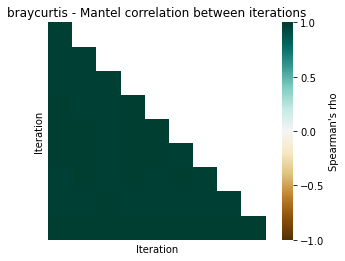

In [14]:
choices = ('matching', 'aitchison', 'euclidean', 'generalized_unifrac', 'canberra', 'russellrao', 'braycurtis', 'cosine', 'jensenshannon', 'yule', 'weighted_normalized_unifrac', 'unweighted_unifrac', 'hamming', 'weighted_unifrac', 'cityblock', 'sokalmichener', 'seuclidean', 'rogerstanimoto', 'correlation', 'minkowski', 'kulsinski', 'chebyshev', 'sqeuclidean', 'sokalsneath', 'jaccard', 'dice', 'canberra_adkins')
clustering_methods = ('nj', 'upgma')
correlation_methods = ('pearson', 'spearman')

sampling_depth = max(min_feature_count, 1)
metric = 'braycurtis'
clustering_method = clustering_methods[0]
correlation_method = correlation_methods[1]

beta_rar = beta_rarefaction(
    table = tabs,
    sampling_depth  = sampling_depth,
    metadata = metadata_qa,
    metric = metric,
    clustering_method = clustering_method,
    correlation_method = correlation_method,
)

 ## Beta diversity PCoA
 Ellipses represent 95% confidence intervals.

In [15]:
plot_tmp = f'{metric}-{clustering_method}-{correlation_method}-{sampling_depth}'
beta_rarefaction_view_path = os.path.join(qiime_folder, f'beta-rarefaction-{plot_tmp}.qzv')
beta_rar.visualization.save(beta_rarefaction_view_path)

beta_rar.visualization

<visualization: Visualization uuid: 32b45b58-03c7-41c5-85bd-7ebadf6faae2>